## Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
plt.rcParams['figure.figsize'] = [6, 5]
import warnings
warnings.filterwarnings('ignore')

## Data Collection and Preprocessing

Now, I have gathered summer and winter data that is required. Some data-prepocessing is done as checking NaN values in dataset, and replacing it with interpolated values.
We have taken data from 6 am to 6 pm as the data from unocuupied period is not useful to make model.
Here, I have added target variable values in dataset. For each fault, I have given different labels from 1 to 7 as shown in below table.

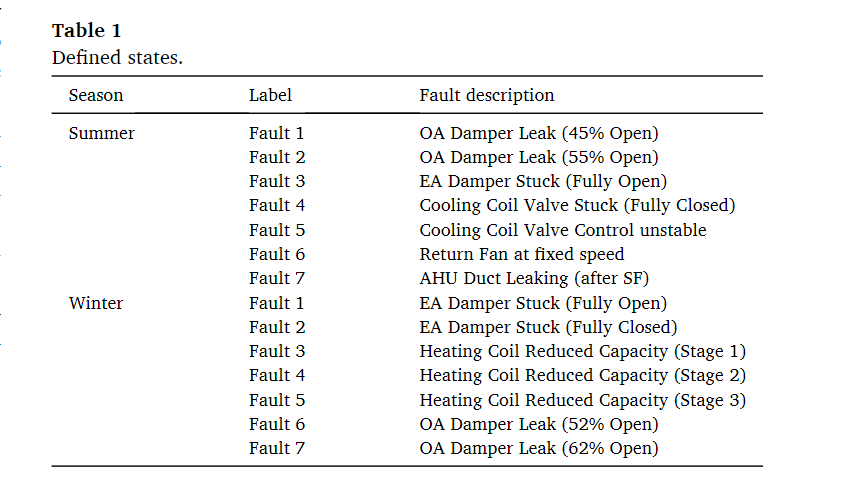

In [2]:

pathw = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\winter_data_defined'
paths = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\summer_data_defined'

filename_s = glob.glob(paths + "\*.xls")
filename_w = glob.glob(pathw + "\*.xls")

df_s = pd.DataFrame()
df_w = pd.DataFrame()
df = [df_s, df_w]
filenames = [filename_s, filename_w]
#Merge all data files in df dataframe
for i in range(len(df)):
    for j in range(len(filenames[i])):
        data = pd.read_excel(filenames[i][j], 'A')  
       
        df[i] = pd.concat([df[i],data])
        
df_s = df[0] #summer data
df_w = df[1] #winter data

dc_s , dc_w = {}, {}
dc = [dc_s , dc_w]

for i in range(len(df)):
    for j in range(len(filenames[i])):
        dc[i][j] = df[i].iloc[361+1440*j:1081+1440*j,:]
        

        #Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(df)):
    for j in range(len(filenames[i])):
        if dc[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dc[i][j] = dc[i][j].interpolate(method ='linear', limit_direction ='forward') 


#Add target variable for multiclass classifier (sequence acording to paper)
s = [3,6,0,5,0,4,1,2,7]    
w = [0,0,0,1,2,3,4,5,6,7]
fault_state = [s,w]
for i in range(len(df)):
    for j in range(len(fault_state[i])):
         
        dc[i][j].loc[:,'y']= fault_state[i][j]
        

In [3]:
dc

[{0:          DATE  TIME  SYS-CTL  RF-CTRL  ECONCTRL  ACCH-SEL  HWC-VLV  CHWC-VLV  \
  361   8202007   601        1        1         1         1    100.0     0.000   
  362   8202007   602        1        1         1         1    100.0     0.000   
  363   8202007   603        1        1         1         1    100.0     0.000   
  364   8202007   604        1        1         1         1    100.0     0.000   
  365   8202007   605        1        1         1         1    100.0     0.000   
  ...       ...   ...      ...      ...       ...       ...      ...       ...   
  1076  8202007  1756        1        1         1         1    100.0    60.227   
  1077  8202007  1757        1        1         1         1    100.0    59.918   
  1078  8202007  1758        1        1         1         1    100.0    59.330   
  1079  8202007  1759        1        1         1         1    100.0    58.991   
  1080  8202007  1800        0        1         1         1    100.0    58.358   
  
        EA

Below I have collected all fault data from AHU A. Some minor modifications is done in dataset like dropping unnecessary features.

In [4]:
# Collect only fault data from both seasons AHU A

fault_date_s = [0,1,3,5,6,7,8]   #locations of fault data files summer
fault_date_w = [3,4,5,6,7,8,9]   #locations of fault data files winter
fd = [fault_date_s,fault_date_w]

dc_fs, dc_fw = pd.DataFrame(), pd.DataFrame()
dc_f = [dc_fs, dc_fw]
for i in range(len(fd)):
    for j in fd[i]:
        data = dc[i][j]
        dc_f[i] = pd.concat([dc_f[i],data])
        
dc_fs = dc_f[0]
dc_fw = dc_f[1]

dc_fs = dc_fs.reset_index()
dc_fw = dc_fw.reset_index()
#Drop unnecessay column variables
dc_fs = dc_fs.drop(['index','DATE','TIME'], axis=1)  # Summer fault data
dc_fw = dc_fw.drop(['index','DATE','TIME'], axis=1)  # Winter fault data

Print data to verify if it is correct.

In [5]:
dc_fw

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E,y
0,1,1,0,1,100.000,0.0,100.0,25.0,25.0,1,...,0.281,9.852,0.0,0.121,0.086,0.002,0.401,0.199,0.245,1
1,1,1,0,1,100.000,0.0,100.0,25.0,25.0,1,...,0.284,0.426,0.0,0.191,0.108,0.003,1.362,0.762,0.571,1
2,1,1,0,1,100.000,0.0,100.0,25.0,25.0,1,...,0.219,-3.487,0.0,0.289,0.128,0.002,1.948,1.201,0.644,1
3,1,1,0,1,100.000,0.0,100.0,25.0,25.0,1,...,0.280,1.754,0.0,0.422,0.163,0.002,0.903,4.591,0.997,1
4,1,1,0,1,100.000,0.0,100.0,25.0,25.0,1,...,0.216,0.263,0.0,0.570,0.189,0.002,1.615,1.760,3.059,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,1,1,1,1,80.452,0.0,47.0,47.0,62.0,1,...,0.235,6.285,0.0,0.983,0.267,0.002,0.081,0.003,0.941,7
5036,1,1,1,1,80.471,0.0,47.0,47.0,62.0,1,...,0.309,5.047,0.0,0.998,0.275,0.002,0.084,0.004,1.022,7
5037,1,1,1,1,80.475,0.0,47.0,47.0,62.0,1,...,0.236,7.560,0.0,0.990,0.272,0.002,0.084,0.003,1.000,7
5038,1,1,1,1,80.410,0.0,47.0,47.0,62.0,1,...,0.237,6.806,0.0,0.998,0.274,0.002,0.084,0.004,1.003,7


Collecting normal data from AHU B. Target variable is added here. Some data preprocessing is done same as for AHU A.

In [6]:
#Normal data from AHU B

df_sb = pd.DataFrame()
df_wb = pd.DataFrame()
df_b = [df_sb, df_wb]
s_n = [2,3,4]            #locations of normal data files summer
w_n = [0,1,2]            #locations of normal data files winter
n = [s_n,w_n]

#Merge all data files in df dataframe
for i in range(len(n)):
    for j in n[i]:
        data1 = pd.read_excel(filenames[i][j], 'B')              
        df_b[i] = pd.concat([df_b[i],data1])
        
df_sb = df_b[0]
df_wb = df_b[1]

dc_sb , dc_wb = {},{}
dcb = [dc_sb , dc_wb]

for i in range(len(df_b)):
    for j in range(len(s_n)):
        dcb[i][j] = df_b[i].iloc[361+1440*j:1081+1440*j,:]
        
        
#Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(df)):
    for j in range(len(s_n)):
        if dcb[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dcb[i][j] = dcb[i][j].interpolate(method ='linear', limit_direction ='forward')  
            
#Add target variable for multiclass classifier (normal data - 0)
for i in range(len(dcb)):
    for j in range(3):
        dcb[i][j].loc[:,'y']= 0
        
        
        
data_s, data_w = pd.DataFrame(), pd.DataFrame()
data_ = [data_s, data_w]
for i in range(len(df_b)):
    for j in range(len(s_n)):
        data = dcb[i][j]
        data_[i] = pd.concat([data_[i], data] )  
        
data_s = data_[0]
data_w = data_[1]

data_s = data_s.reset_index()
data_w = data_w.reset_index()

#Drop unnecessay column variables
data_s = data_s.drop(['index','DATE','TIME'], axis=1) #summer normal data AHU B
data_w = data_w.drop(['index','DATE','TIME'], axis=1) #winter normal data AHU B  

In [7]:
data_w

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E,y
0,1,1,0,1,100.000,0.0,0.0,0.0,0.0,1,...,-0.199,23.562,0.0,0.129,0.095,0.003,0.004,0.003,0.001,0
1,1,1,0,1,100.000,0.0,25.0,25.0,25.0,1,...,-0.253,-10.489,0.0,0.158,0.100,0.003,3.574,0.866,0.270,0
2,1,1,0,1,100.000,0.0,25.0,25.0,25.0,1,...,-0.264,-0.594,0.0,0.230,0.115,0.003,4.438,0.544,0.604,0
3,1,1,0,1,100.000,0.0,25.0,25.0,25.0,1,...,-0.264,3.512,0.0,0.349,0.142,0.003,3.283,1.964,0.697,0
4,1,1,0,1,100.000,0.0,25.0,25.0,25.0,1,...,-0.205,2.988,0.0,0.485,0.187,0.003,3.272,1.820,2.846,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,1,1,1,1,82.849,0.0,50.0,50.0,50.0,1,...,-0.168,5.315,0.0,1.037,0.321,0.002,0.934,0.838,1.430,0
2156,1,1,1,1,82.809,0.0,50.0,50.0,50.0,1,...,-0.167,3.359,0.0,1.035,0.322,0.002,0.962,0.840,1.466,0
2157,1,1,1,1,82.796,0.0,50.0,50.0,50.0,1,...,-0.167,4.098,0.0,1.041,0.321,0.002,0.993,0.764,1.435,0
2158,1,1,1,1,82.859,0.0,50.0,50.0,50.0,1,...,-0.167,3.619,0.0,1.043,0.322,0.002,0.997,0.683,1.438,0


## Steady State Detection

Training data is collected for SSD. The threshold for the steady-state detection was set by referring to the slope of the steady-state section. The selected reference section for summer was 2008/9/4 14:00-18:00[22], when the system was operated in  the  steady-state, and the  selected reference section for winter was 2008/2/17 14:00-18:00. The threshold was set to three times the  standard deviation of  the  sum of  the  slopes under steady-state conditions.[22]

In [8]:
# normal data for determing threshold of slope in summer  2007/09/04 14:00 - 18:00
train_ss_s = pd.read_excel(r"E:\Prasad\IITM\AHRAE-D-RP-1312-EXCEL DATA\Experiment\Fault test\2007summer\20070904.xls", 'A').iloc[841:1080]

# normal data for determing threshold of slope in winter  2008/02/17 14:00 - 18:00  
train_ss_w = pd.read_excel(r"E:\Prasad\IITM\AHRAE-D-RP-1312-EXCEL DATA\Experiment\Fault test\2008winter\20080217.xls", 'A').iloc[841:1080]

In this study, a steady-state filtering method [15,21–23] based on the change rate of the reference variable was used. Five reference variables were set as follows: cooling and heating coil control signal, SA duct pressure, SA temperature, supply fan speed [15].  The steady-state indicator is the sum of the change rates of the reference variables. When the  indicator exceeds the  threshold, which is  set  in advance by referring to data under the steady-state, it is determined as transient-state with severe variation; when the indicator is lower than the threshold, it is determined as steady-state.


In [9]:
# Data preprocessing- steady state detection based on slope method described in paper

# Import steady state detection module developed according to papaer
from SSD import *

#summer steady state data
steady_st_data_sf = SSD(train_ss_s,dc_fs)  # Steady state fault data of summer
steady_st_data_sn = SSD(train_ss_s,data_s) # steady state normal data of summer

#winter steady state data
steady_st_data_wf = SSD(train_ss_w,dc_fw)  # Steady state fault data of winter
steady_st_data_wn = SSD(train_ss_w,data_w) # steady state normal data of winter

Print Steady state data for one dataset

In [10]:
steady_st_data_wf

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E,y
12,1.0,1.0,0.0,1.0,100.000,0.0,100.0,35.0,35.0,1.0,...,0.281,0.000,0.0,0.959,0.301,0.003,2.321,2.080,2.234,1.0
13,1.0,1.0,0.0,1.0,100.000,0.0,100.0,35.0,35.0,1.0,...,0.281,0.000,0.0,0.927,0.301,0.002,2.310,2.227,1.995,1.0
14,1.0,1.0,0.0,1.0,100.000,0.0,100.0,35.0,35.0,1.0,...,0.348,0.000,0.0,0.921,0.302,0.003,2.190,2.291,1.730,1.0
110,1.0,1.0,1.0,1.0,81.987,0.0,100.0,47.0,47.0,1.0,...,0.283,4.572,0.0,0.996,0.317,0.001,2.277,1.377,1.317,1.0
111,1.0,1.0,1.0,1.0,81.868,0.0,100.0,47.0,47.0,1.0,...,0.344,4.838,0.0,0.991,0.314,0.001,2.336,1.409,1.393,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,1.0,1.0,1.0,1.0,80.452,0.0,47.0,47.0,62.0,1.0,...,0.235,6.285,0.0,0.983,0.267,0.002,0.081,0.003,0.941,7.0
5036,1.0,1.0,1.0,1.0,80.471,0.0,47.0,47.0,62.0,1.0,...,0.309,5.047,0.0,0.998,0.275,0.002,0.084,0.004,1.022,7.0
5037,1.0,1.0,1.0,1.0,80.475,0.0,47.0,47.0,62.0,1.0,...,0.236,7.560,0.0,0.990,0.272,0.002,0.084,0.003,1.000,7.0
5038,1.0,1.0,1.0,1.0,80.410,0.0,47.0,47.0,62.0,1.0,...,0.237,6.806,0.0,0.998,0.274,0.002,0.084,0.004,1.003,7.0


## Model Building
The first step in building the model is to select the input variables. When many types of  input variables are  needed for  the  model, the introduction cost and model complexity increase because of  the increased number of sensors to be installed. Therefore, the appropriate input variables should be selected to minimize the number of required input variables while securing the accuracy of the model. In this study, 13 input variables were selected as shown in Table 4 based on the usual sensors installed in AHU [33] and potential sensors [22] that can be installed for FDD.

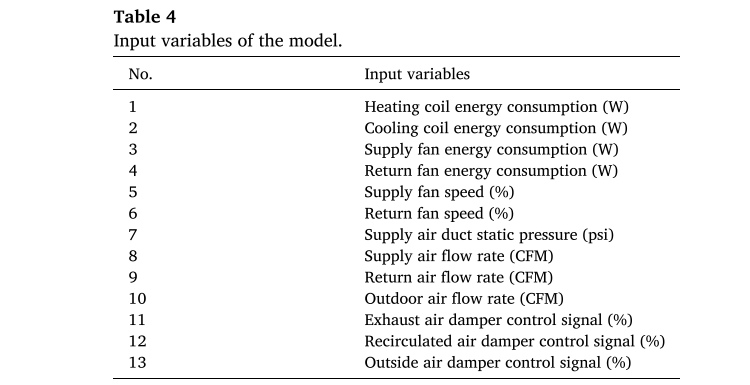

In [11]:
# Input variables of model
input_var = ['E_hcoil','E_ccoil','SF-WAT','RF-WAT','SF-SPD','RF-SPD','SA-SP','SA-CFM','RA-CFM','OA-CFM','EA-DMPR','RA-DMPR','OA-DMPR','HWC-LWT']

steady_st_data_sf = steady_st_data_sf.reset_index()
steady_st_data_sf = steady_st_data_sf.drop(['index'], axis=1)

steady_st_data_wf = steady_st_data_wf.reset_index()
steady_st_data_wf = steady_st_data_wf.drop(['index'], axis=1)

steady_st_data_sn = steady_st_data_sn.reset_index()
steady_st_data_sn = steady_st_data_sn.drop(['index'], axis=1)

steady_st_data_wn = steady_st_data_wn.reset_index()
steady_st_data_wn = steady_st_data_wn.drop(['index'], axis=1)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  6.,  4.,  4.,  7., 13., 30., 28.,  1., 11., 13., 10., 11.,
         5., 11., 21., 18., 16., 26., 14.,  5.,  0.,  4.,  9.,  9.,  9.,
         3.,  3., 23., 22., 13., 34.,  6.,  1.,  1.,  0.,  0.,  0.,  4.,
        14.,  9.,  3.,  1.,  4.,  6., 11., 12.]),
 array([ 544.495     ,  564.79158333,  585.08816667,  605.38475   ,
         625.68133333,  645.97791667,  666.2745    ,  686.57108333,
         706.86766667,  727.16425   ,  747.46083333,  767.75741667,
         788.054     ,  808.35058333,  828.64716667,  848.94375   ,
         869.24033333,  889.53691667,  909.8335    ,  930.13008333,
         950.42666667,  970.72325   ,  991.01983333, 1011.31641667,
        1031.613     , 1051.90958333, 1072.20616667, 1092.50275   ,
        1112.79933333, 1133.09591667, 1153.3925    , 1173.68908333,
        1193.98566667, 1214.28225   , 1234.57883333, 1254.87541667,
        1275.172     , 1295.46858333, 1315.765

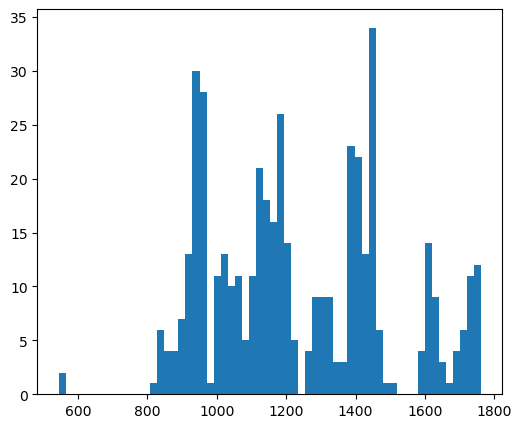

In [12]:
plt.hist(steady_st_data_sn['SF-WAT'],bins=60)

## Winter Data Model Building

In paper, Steady state data is standardized by standard deviation method. In this standardized values can be negative or positive. this is causing problem while selecting activation function for autoencoder. ReLu returns zero for negative values, so mean squared error is larger in this case.( For classification it gives good results.) So I have used MinMaxscalar which uses minimum and maximum values for standardization of data, the values will not be negative in this case. so the decoder give good accuracy with ReLu activation function.

I have used linear unit(activation='linear', f(z)=z) for decoder layer as given in the paper. then i got good results for recontruction with standardized input with StandardScaler()

The fault-free data is split into training and validation data, and fault data is split into training, testing and validation set.

Keras provides numpy utility library, which provides functions to perform actions on numpy arrays. Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [13]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Normalize data between 0 and 1 using Minmaxscaler
from sklearn import preprocessing

scale = preprocessing.StandardScaler()

# Winter data
Xnw=steady_st_data_wn[input_var] # Features
Ynw=steady_st_data_wn['y']  # Labels

Xfw=steady_st_data_wf[input_var] # Features
Yfw=steady_st_data_wf['y']  # Labels

# Split dataset into training set and test set- Normal data
X_trainnw, X_valnw, y_trainnw, y_valnw = train_test_split(Xnw.values, Ynw, test_size=0.2) # 80% training and 20% test
# Split dataset into training set and test set- Fault data
X_trainfw_, X_testfw, y_trainfw_, y_testfw = train_test_split(Xfw.values, Yfw, test_size=0.2) # splitting in train and test
# Split dataset into training set and validation set- Fault data
X_trainfw, X_valfw, y_trainfw, y_valfw = train_test_split(X_trainfw_, y_trainfw_, test_size=0.25) # splitting in train and validation test


#def standard(X):
#    X_mean = X.mean(axis=0)
#    X_std = X.std(axis=0)
#    X_sc = (X-X_mean)/X_std
#    return X_sc, X_mean, X_std


#def standardize_und(X_und):
#    X_stdu = (X_und-meanXtr)/stdXtr
#    return X_stdu

x_trainw = np.concatenate([X_trainnw,X_trainfw])
y_trainw = np.concatenate([y_trainnw,y_trainfw])
x_valw = np.concatenate([X_valnw,X_valfw])
y_valw = np.concatenate([y_valnw,y_valfw])

#[x_trainw, meanXtr,stdXtr]  = standard(x_trainw)
#x_valw = standardize_und(x_valw)
scale.fit(x_trainw)
x_trainw = scale.transform(x_trainw)
x_valw = scale.transform(x_valw)

from keras.utils.np_utils import to_categorical
y_trainw = to_categorical(y_trainw)
y_valw = to_categorical(y_valw)
y_testfw = to_categorical(y_testfw)

In [14]:
scale.mean_

array([ 5.25949492e+00, -1.74217161e-03,  1.07618690e+03,  2.99296593e+02,
        7.07224327e+01,  5.66167674e+01,  1.38562098e+00,  1.74892675e+03,
        1.72002233e+03,  6.81940902e+02,  4.92530362e+01,  4.77190793e+01,
        5.05454315e+01,  7.53512562e+01])

In [15]:
scale.scale_

array([2.97241846e+00, 1.85383826e-02, 2.12339315e+02, 4.50671458e+01,
       5.82893804e+00, 4.32726806e+00, 1.38957501e-01, 3.25769601e+02,
       2.83582995e+02, 1.59884498e+02, 2.16665291e+01, 6.90621704e+00,
       8.47323622e+00, 7.69802135e+00])

Print some data to verify it

In [16]:
y_valw

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [17]:
x_valw

array([[-0.47385485,  0.09397646, -0.29815438, ...,  0.33027064,
        -0.06437109, -0.19904546],
       [ 0.33726916,  0.09397646, -0.62351099, ...,  0.33027064,
        -0.06437109,  1.11440894],
       [-0.22759074,  0.09397646, -0.20440349, ...,  0.33027064,
        -0.06437109, -0.29582358],
       ...,
       [ 1.28531872,  0.09397646, -0.6718393 , ..., -0.10412058,
         0.17166623,  0.03179308],
       [ 0.43315068,  0.09397646, -0.33535427, ..., -0.10412058,
         1.35185285, -0.03731559],
       [-1.41618516,  0.09397646, -0.51738839, ..., -0.10412058,
        -0.41842708, -0.9479392 ]])

In [18]:
# Data visualization 
import seaborn as sns

# Keras
import keras
from keras.models import Sequential
from keras import layers, losses
from keras.layers import Dense, Dropout, Concatenate, BatchNormalization
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K

# Classification Report
from sklearn.metrics import classification_report


## Model Training

Next, the hyperparameters required for implementing the SAE of the operation unit were set heuristically. The input layer consisted of 13 nodes, which was the same as the number of types of input variables.

The encoder consisted of 300 nodes, and the rectified linear unit (ReLu) was used as the activation function of the encoder layer. In addition, batch-normalization and dropout were applied for generalization performance [37,38]. The classifier consisted of eight nodes, and each node denoted the fault-free state and seven faults. The softmax function [39] was applied as  the  activation function of  the  classifier. The decoder comprised 13 nodes, which is the same number of the input variable types, and each node represents the reconstructed input variable. The linear unit was applied as the activation function of the decoder.


In [19]:
input_data = keras.Input(shape=(14,)) ## Input layer
encoded = layers.Dense(300, activation='relu')(input_data) ## Encoder layer
encoded = keras.layers.BatchNormalization()(encoded)
encoded = keras.layers.Dropout(0.3)(encoded)
decoded = layers.Dense(14, activation='linear', name='cont_out')(encoded) ## Decoder layer
classified = layers.Dense(8, activation = 'linear',name='cat_out')(encoded)  ## Classification layer

### Numerical Stability

The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution. Therefore, the output layer in this case does not have a softmax activation function.
The softmax function would be automatically applied on the output values by the loss function. Therefore, this does not make a difference with the scenario when you use from_logits=False (default) and a softmax activation function on last layer; however, in some cases, this might help with numerical stability during training of the model.

#### Previous code
classified = layers.Dense(8, activation = 'softmax',name='cat_out')(encoded)
autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
                    'cat_out': 'categorical_crossentropy'},)
                    
#### Modified code                    
classified = layers.Dense(8, activation = 'linear',name='cat_out')(encoded)
autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
                    'cat_out': losses.CategoricalCrossentropy(from_logits=True)},)

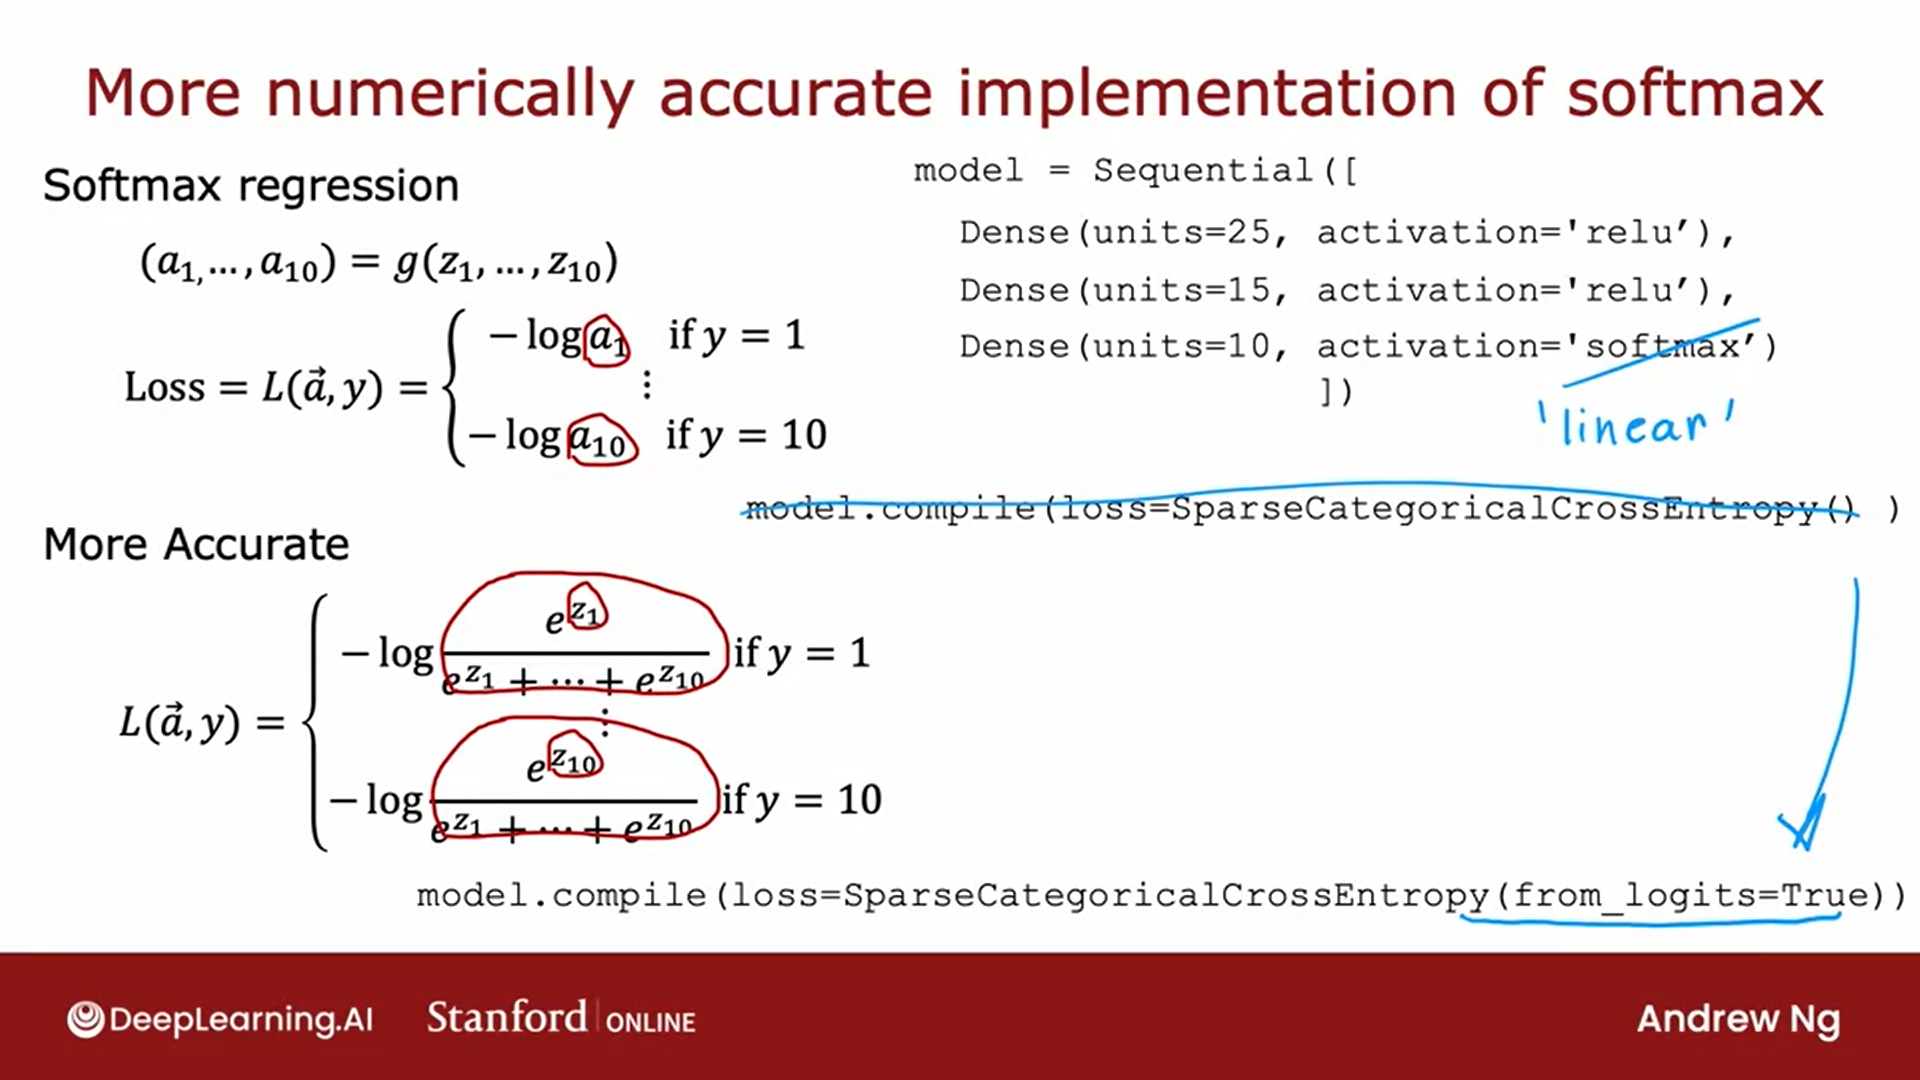

###  Early stopping

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)

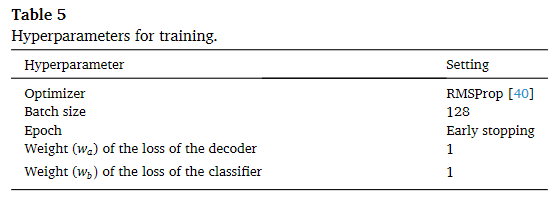

## Operation Unit Training

The operation unit was trained using the training process proposed in Section 2.2.1. The model for the cooling mode of the AHU system was trained using the summer data, and for the heating mode, the model was trained using the winter data individually. The hyperparameters required for  training were configured through an  empirical method using a validation set, as shown in Table 5. 

Figure below illustrate the operation unit training results of summer and winter, respectively. They depict losses according to the epoch of the training and validation sets. It can be seen that as the training progressed, the losses of the training and validation sets approached zero, indicating that the training of  the operation unit was performed appropriately.

In [21]:
autoencoder = keras.Model(input_data ,outputs= [decoded, classified])

#autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
#                    'cat_out': 'categorical_crossentropy'},)
autoencoder.compile(optimizer='RMSprop', loss={'cont_out': 'mse', 
                    'cat_out': losses.CategoricalCrossentropy(from_logits=True)},)

history = autoencoder.fit(x_trainw, {'cont_out': x_trainw, 'cat_out': y_trainw},
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_valw, {'cont_out': x_valw, 'cat_out': y_valw}),callbacks=[callback])

Epoch 1/100
20/20 [==============================] - 1s 13ms/step - loss: 2.3389 - cont_out_loss: 1.3228 - cat_out_loss: 1.0161 - val_loss: 2.2002 - val_cont_out_loss: 0.6294 - val_cat_out_loss: 1.5708
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2174 - cont_out_loss: 0.8589 - cat_out_loss: 0.3585 - val_loss: 2.0102 - val_cont_out_loss: 0.6229 - val_cat_out_loss: 1.3873
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.9632 - cont_out_loss: 0.7446 - cat_out_loss: 0.2186 - val_loss: 1.8315 - val_cont_out_loss: 0.6045 - val_cat_out_loss: 1.2270
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.8039 - cont_out_loss: 0.6523 - cat_out_loss: 0.1516 - val_loss: 1.6641 - val_cont_out_loss: 0.5781 - val_cat_out_loss: 1.0860
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7310 - cont_out_loss: 0.6150 - cat_out_loss: 0.1160 - val_loss: 1.5035 - val_cont_out_loss: 0.5532 - val_cat_out_loss: 0

20/20 [==============================] - 0s 3ms/step - loss: 0.0530 - cont_out_loss: 0.0483 - cat_out_loss: 0.0047 - val_loss: 0.0345 - val_cont_out_loss: 0.0128 - val_cat_out_loss: 0.0217
Epoch 42/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0451 - cont_out_loss: 0.0404 - cat_out_loss: 0.0047 - val_loss: 0.0370 - val_cont_out_loss: 0.0269 - val_cat_out_loss: 0.0101
Epoch 43/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0552 - cont_out_loss: 0.0483 - cat_out_loss: 0.0069 - val_loss: 0.1001 - val_cont_out_loss: 0.0847 - val_cat_out_loss: 0.0154
Epoch 44/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0444 - cont_out_loss: 0.0378 - cat_out_loss: 0.0066 - val_loss: 0.0209 - val_cont_out_loss: 0.0077 - val_cat_out_loss: 0.0132
Epoch 45/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0464 - cont_out_loss: 0.0406 - cat_out_loss: 0.0058 - val_loss: 0.0228 - val_cont_out_loss: 0.0099 - val_cat_out_loss: 0.0129
Epo

dict_keys(['loss', 'cont_out_loss', 'cat_out_loss', 'val_loss', 'val_cont_out_loss', 'val_cat_out_loss'])


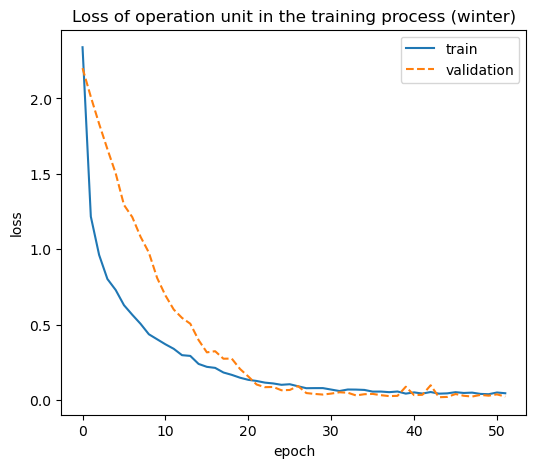

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='--')
plt.title('Loss of operation unit in the training process (winter)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Threshold setting

The threshold was set after training of the operation unit by applying the  three-sigma rule to  the  reconstruction error of  the  training set. Figs. 7 and 8 show the reconstruction error distribution and threshold of each model. The solid line indicates the reconstruction error distribution of the training set, which is expressed as the kernel density estimate. The dashed line indicates the reconstruction error distribution of the validation set. The one-point dashed line indicates the threshold. Most of the validation set reconstruction errors were lower than the threshold. This means that the validation set was the data of defined states, and the FDD model can significantly infer the input variables of the validation set.

24/24 [==============================] - 0s 1ms/step


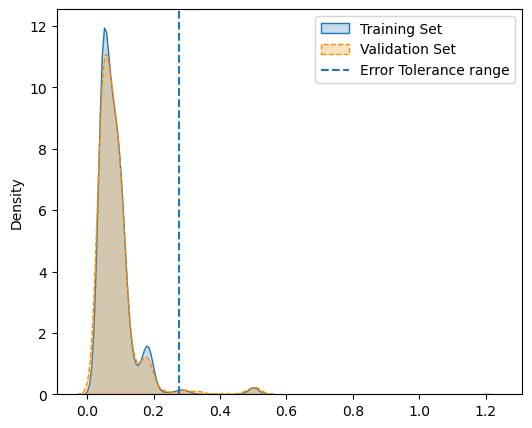

In [23]:
# Prediction of output with developed model
[recontructed_input_t,classification_t]= autoencoder.predict(x_trainw)
[recontructed_input_v,classification_v]= autoencoder.predict(x_valw)

#classification_v = tf.nn.softmax(classification_v).numpy()

# Evaluation of recontruction error for both training and validation set
recontruct_error_t = tf.keras.losses.mse(recontructed_input_t, x_trainw)
recontruct_error_t = np.sqrt(recontruct_error_t)
recontruct_error_v = tf.keras.losses.mse(recontructed_input_v, x_valw)
recontruct_error_v = np.sqrt(recontruct_error_v)

# Setting recontruction error threshold
recontruct_error_t_std = np.std(recontruct_error_t)
rec_err_thr = 3*recontruct_error_t_std + sum(recontruct_error_t)/len(recontruct_error_t)

# Plotting density plot for recontruction error for both training and validation set
fig = sns.kdeplot(recontruct_error_t, shade=True, label='Training Set')
fig = sns.kdeplot(recontruct_error_v, shade=True,color="darkorange", linestyle='--', label= 'Validation Set')
plt.axvline(x=rec_err_thr, linestyle='--', label= 'Error Tolerance range')
plt.legend()


In [24]:
[recontructed_input_v,classification_v]= autoencoder.predict(x_valw)
recontructed_input_v

24/24 [==============================] - 0s 864us/step


array([[-0.45069894,  0.03899665, -0.23030192, ...,  0.27974585,
        -0.02346553, -0.17499766],
       [ 0.38428417,  0.13489339, -0.7072935 , ...,  0.24588774,
        -0.12491973,  1.1109363 ],
       [-0.21469137,  0.02795604, -0.16084991, ...,  0.3129907 ,
        -0.01411483, -0.2987462 ],
       ...,
       [ 1.1271651 ,  0.09937273, -0.7174764 , ..., -0.01256355,
         0.15792395,  0.21195114],
       [ 0.34438062,  0.03956305, -0.38775378, ..., -0.01233838,
         1.1997383 , -0.02598577],
       [-1.2272011 ,  0.38432246, -0.3328206 , ..., -0.3017143 ,
        -0.4991405 , -0.87822217]], dtype=float32)

In [25]:
classification_v


array([[ 15.94916   ,   0.02667531,  -2.661318  , ...,   2.5220683 ,
         -3.850836  ,  -3.4364572 ],
       [ 14.176179  ,  -3.4802403 ,  -4.2366796 , ...,  -7.412158  ,
          2.8087394 ,  -1.3265018 ],
       [ 17.940079  ,   0.8629827 ,  -1.9763799 , ...,   4.429664  ,
         -4.944347  ,  -3.287652  ],
       ...,
       [ -2.514933  ,  -4.5464883 ,  -1.454664  , ...,  -7.5808105 ,
          9.355647  ,   2.611496  ],
       [ -2.3227127 ,  -0.5649453 ,   3.6278534 , ...,  -5.3084693 ,
          6.4368467 ,  16.19657   ],
       [-19.224045  , -12.244297  ,  20.252985  , ...,   1.039033  ,
         -0.82920593,  -5.413129  ]], dtype=float32)

In [26]:
y_pre = tf.nn.softmax(classification_v).numpy()
pd.DataFrame(y_pre)

,0,1,2,3,4,5,6,7
0,9.999982e-01,1.216052e-07,8.271258e-09,1.849094e-07,3.977376e-09,1.474645e-06,2.517506e-09,3.810071e-09
1,9.999566e-01,2.147314e-08,1.007809e-08,3.162893e-05,2.395109e-08,4.210033e-10,1.156552e-05,1.850344e-07
2,9.999986e-01,3.832750e-08,2.240740e-09,3.162314e-09,3.132220e-10,1.356754e-06,1.151912e-10,6.038283e-10
3,1.000000e+00,2.768390e-09,4.452779e-11,8.211950e-12,5.361855e-11,3.499406e-09,3.072838e-13,1.921439e-11
4,9.999955e-01,1.214225e-08,1.180235e-08,1.036594e-06,8.250842e-10,1.640449e-11,2.702283e-06,7.316541e-07
...,...,...,...,...,...,...,...,...
761,2.012808e-09,1.000000e+00,4.431422e-14,1.116608e-08,3.466468e-10,4.116581e-09,1.227128e-10,5.630172e-11
762,4.392177e-10,8.503481e-09,4.483948e-07,1.448218e-10,1.182057e-10,3.546006e-11,1.267015e-05,9.999869e-01
763,6.983875e-06,9.158054e-07,2.016348e-05,1.138768e-05,1.095702e-04,4.405686e-08,9.986749e-01,1.176187e-03
764,9.060490e-09,5.254605e-08,3.478959e-06,1.063164e-10,3.198270e-09,4.575658e-10,5.772709e-05,9.999387e-01


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [28]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print("\nConfusion Matrix: \n",
        confusion_matrix(y_test, y_pred))
      
    print ("\nAccuracy : \n",
    accuracy_score(y_test,y_pred)*100)
      
    print("\nReport :\n ",
    classification_report(y_test, y_pred))

In [29]:
def classif_report(y_test, y_pred):
    a = len(y_pred)
    y_pred1 = tf.nn.softmax(y_pred).numpy()
    y_p = np.zeros(a)
    y_pv = np.zeros(a)
    y_pre = np.zeros((a,8))
    for i in range(a):
        for j in range(8):
            if y_pred1[i][j]>= 0.1:
                y_pre[i][j] = 1
            if y_pre[i][j] == 1:
                y_p[i] = j
            if y_test[i][j] == 1:
                y_pv[i] = j

    cal_accuracy(y_pv, y_p)
        

In [30]:
classif_report(y_valw,classification_v)


Confusion Matrix: 
 [[167   0   0   0   0   0   0   0]
 [  0  80   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0]
 [  0   0   0  82   0   0   0   0]
 [  0   0   0   0  93   0   0   0]
 [  0   0   0   0   0  65   0   0]
 [  0   0   0   0   0   0 106   0]
 [  0   0   0   0   0   0   1 126]]

Accuracy : 
 99.86945169712794

Report :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       167
         1.0       1.00      1.00      1.00        80
         2.0       1.00      1.00      1.00        46
         3.0       1.00      1.00      1.00        82
         4.0       1.00      1.00      1.00        93
         5.0       1.00      1.00      1.00        65
         6.0       0.99      1.00      1.00       106
         7.0       1.00      0.99      1.00       127

    accuracy                           1.00       766
   macro avg       1.00      1.00      1.00       766
weighted avg       1.00      1.00      1.00       766



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 300)          4500        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 300)         1200        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 300)          0           ['batch_normalization[0][0]']

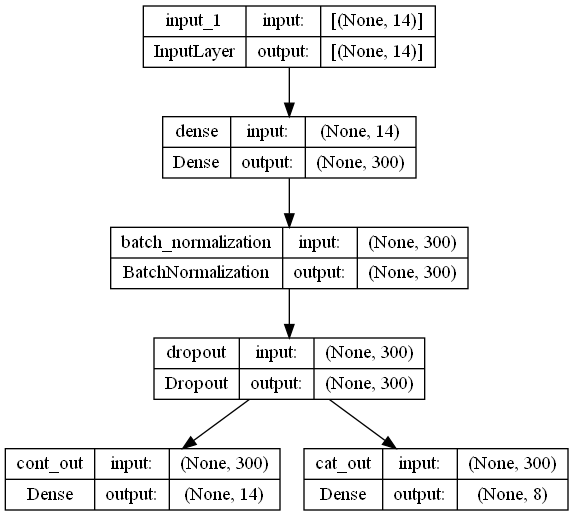

In [31]:
from tensorflow.keras.utils import plot_model
#Model Details
autoencoder.summary()
keras.utils.plot_model(autoencoder, "output.png", show_shapes=True)

### Undefined data collection

In [32]:
## Undefined state data collection for summer and winter

pathwu = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\test_set_undefined\winter'
pathsu = r'E:\Prasad\IITM\ASHRAE DATA  acc to papers\Undefined_state_data_ashrae\test_set_undefined\summer'

filename_su = glob.glob(pathsu + "\*.xls")
filename_wu = glob.glob(pathwu + "\*.xls")

df_su = pd.DataFrame()
df_wu = pd.DataFrame()
dfu = [df_su, df_wu]
filenamesu = [filename_su, filename_wu]
#Merge all data files in df dataframe
for i in range(len(dfu)):
    for j in range(len(filenamesu[i])):
        datau = pd.read_excel(filenamesu[i][j], 'A')              
        dfu[i] = pd.concat([dfu[i],datau])
        
df_su = dfu[0] #summer data
df_wu = dfu[1] #winter data

dc_su , dc_wu = {}, {}
dcu = [dc_su , dc_wu]

for i in range(len(dfu)):
    for j in range(len(filenamesu[i])):
        dcu[i][j] = dfu[i].iloc[361+1440*j:1081+1440*j,:]
        

        #Check mising values, and if there are NaN values, it will replaced by interpolating values (Missing data in 22/08/2007  )
for i in range(len(dfu)):
    for j in range(len(filenamesu[i])):
        if dcu[i][j].isnull().sum().sum() != 0:   #check total no of NaN values
            dcu[i][j] = dc[i][j].interpolate(method ='linear', limit_direction ='forward') 
            
          

In [33]:


# Collect only undefined data from both seasons AHU A

fault_date_su = [0,1,2,4,5,6,7,8,9,10] #locations of fault data files summer
ysu = [11,12,13,14,15,16,17,18,19,20]
fault_date_wu = [3,4,8,9,10]   #locations of fault data files winter
ywu = [11,12,13,14,15]
fd1 = [fault_date_su,fault_date_wu]
yu = [ysu,ywu]
dc_fsu, dc_fwu = pd.DataFrame(), pd.DataFrame()
dc_fu = [dc_fsu, dc_fwu]
for i in range(len(fd1)):
    for j in range(len(fd1[i])):
        #dcu[i][j].loc[:,'y'] = yu[i][j]
        datau = dcu[i][fd1[i][j]]
        dc_fu[i] = pd.concat([dc_fu[i],datau])
        
dc_fsu = dc_fu[0]
dc_fwu = dc_fu[1]

dc_fsu = dc_fsu.reset_index()
dc_fwu = dc_fwu.reset_index()
#Drop unnecessay column variables
dc_fsu = dc_fsu.drop(['index','DATE','TIME'], axis=1)  # Summer fault data
dc_fwu = dc_fwu.drop(['index','DATE','TIME'], axis=1)  # Winter fault data

In [34]:
#dc_fwu = dc_fwu[input_var]
dc_fwu

,SYS-CTL,RF-CTRL,ECONCTRL,ACCH-SEL,HWC-VLV,CHWC-VLV,EA-DMPR,RA-DMPR,OA-DMPR,SF-SST,...,HWC_GPM,CHWC_GPM,E_hcoil,E_ccoil,E_SF,E_RF,E_ZONE_I,E_ZONE_W,E_ZONE_S,E_ZONE_E
0,1,1,0,1,100.0,0.0,0.000,0.000,0.0,1,...,-0.376,0.212,-2.009,0.0,0.108,0.093,0.002,0.018,0.380,0.366
1,1,1,0,1,100.0,0.0,25.000,25.000,25.0,1,...,2.496,0.335,8.516,0.0,0.156,0.094,0.002,1.300,0.579,-0.088
2,1,1,0,1,100.0,0.0,25.000,25.000,25.0,1,...,-0.777,0.274,-3.505,0.0,0.233,0.117,0.002,1.967,0.124,0.519
3,1,1,0,1,100.0,0.0,25.000,25.000,25.0,1,...,0.138,0.146,0.774,0.0,0.349,0.144,0.002,0.942,3.313,0.516
4,1,1,0,1,100.0,0.0,25.000,25.000,25.0,1,...,0.312,0.275,1.772,0.0,0.487,0.180,0.002,1.465,2.504,2.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,1,1,1,1,100.0,0.0,97.267,97.267,0.0,1,...,-0.966,0.405,0.000,0.0,1.119,0.589,0.001,1.069,0.005,0.788
3596,1,1,1,1,100.0,0.0,97.217,97.217,0.0,1,...,-0.966,0.327,0.000,0.0,1.128,0.586,0.001,1.006,0.005,1.211
3597,1,1,1,1,100.0,0.0,97.163,97.163,0.0,1,...,-1.259,0.253,0.000,0.0,1.131,0.600,0.001,1.100,0.005,0.938
3598,1,1,1,1,100.0,0.0,97.129,97.129,0.0,1,...,-1.259,0.405,0.000,0.0,1.094,0.586,0.001,1.047,0.004,1.151


In [35]:
dc_fwu1 = dc_fwu[input_var]

In [36]:
scale1 = preprocessing.StandardScaler()
scale1.fit(dc_fwu1)

StandardScaler()

In [37]:
print(scale1.mean_)
print(scale1.scale_)

[6.06237611e+00 3.81923028e+00 1.20904286e+03 4.07238362e+02
 8.24761892e+01 6.59685022e+01 1.06809944e+00 1.39298788e+03
 1.89623853e+03 4.38321424e+02 5.56855539e+01 5.56015675e+01
 3.76853081e+01 8.42629742e+01]
[  7.99231793   7.07607747 373.88139383 142.32415415  14.92191089
  11.95581312   0.54210019 519.8322293  325.74098354 228.61217112
  18.70343732  18.61126803  19.43734693  14.01557863]


In [38]:
print(scale.mean_)
print(scale.scale_)

[ 5.25949492e+00 -1.74217161e-03  1.07618690e+03  2.99296593e+02
  7.07224327e+01  5.66167674e+01  1.38562098e+00  1.74892675e+03
  1.72002233e+03  6.81940902e+02  4.92530362e+01  4.77190793e+01
  5.05454315e+01  7.53512562e+01]
[2.97241846e+00 1.85383826e-02 2.12339315e+02 4.50671458e+01
 5.82893804e+00 4.32726806e+00 1.38957501e-01 3.25769601e+02
 2.83582995e+02 1.59884498e+02 2.16665291e+01 6.90621704e+00
 8.47323622e+00 7.69802135e+00]


In [39]:
import math
def evaluate_undefined(x_undw):
    a = len(x_undw)
    st_dataw = SSD(train_ss_w,x_undw)
    st_dataw = st_dataw[input_var]
    st_dataw = st_dataw.to_numpy()
    st_dataw = scale.transform(st_dataw)
    #
    
    [recontructed_input_te,classification_te]= autoencoder.predict(st_dataw)
    recontruct_error_v = tf.keras.losses.mse(recontructed_input_te, st_dataw)
    recontruct_error_v = np.sqrt(recontruct_error_v)
    
    classification_te = tf.nn.softmax(classification_te).numpy()
    y=0
    for i in range(len(st_dataw)):
        
        if recontruct_error_v[i]>=rec_err_thr:
            y += 1
    sensitivity = (y/len(st_dataw))          
    return sensitivity

In [40]:
evaluate_undefined(dc_fwu.iloc[0:720])

8/8 [==============================] - 0s 2ms/step


1.0

In [41]:
X_testfw = scale.transform(X_testfw)

In [42]:
X_testfw

array([[-0.04255623,  0.09397646,  0.23833129, ..., -0.10412058,
         0.17166623, -0.54783639],
       [-0.54517725,  0.09397646, -0.36293278, ..., -0.10412058,
        -0.41842708, -0.61681515],
       [ 0.32818565,  0.09397646,  1.07679118, ..., -0.10412058,
         0.17166623,  0.05933262],
       ...,
       [-1.50264674,  0.09397646, -0.40706497, ..., -0.10412058,
        -0.41842708, -1.34817192],
       [-0.13372778,  0.09397646, -0.31329053, ..., -0.10412058,
        -0.41842708, -0.2856911 ],
       [ 0.38638741,  0.09397646, -0.373967  , ..., -0.10412058,
         0.17166623, -0.12006413]])

In [43]:
[recontructed_input_te,classification_te]= autoencoder.predict(X_testfw)

19/19 [==============================] - 0s 1ms/step


In [44]:
classif_report(y_testfw,classification_te)


Confusion Matrix: 
 [[ 79   0   0   0   1   0   0]
 [  0  52   0   0   0   0   0]
 [  0   0  74   0   0   1   0]
 [  0   0   2 108   0   0   0]
 [  0   0   0   0  69   0   0]
 [  0   0   0   0   0 110   0]
 [  0   0   0   0   0   0 103]]

Accuracy : 
 99.33222036727881

Report :
                precision    recall  f1-score   support

         1.0       1.00      0.99      0.99        80
         2.0       1.00      1.00      1.00        52
         3.0       0.97      0.99      0.98        75
         4.0       1.00      0.98      0.99       110
         5.0       0.99      1.00      0.99        69
         6.0       0.99      1.00      1.00       110
         7.0       1.00      1.00      1.00       103

    accuracy                           0.99       599
   macro avg       0.99      0.99      0.99       599
weighted avg       0.99      0.99      0.99       599



In [45]:
# Evaluation of search performance of Undefined state
s = np.zeros(5)
for i in range(5):
    
    a = pd.DataFrame()
    a = dc_fwu.iloc[720*i:720*(i+1)]
    
    s[i] = evaluate_undefined(a)
    

20/20 [==============================] - 0s 2ms/step


In [46]:
s
ss = [s[4],s[2],s[0],s[1],s[3]]

In [47]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

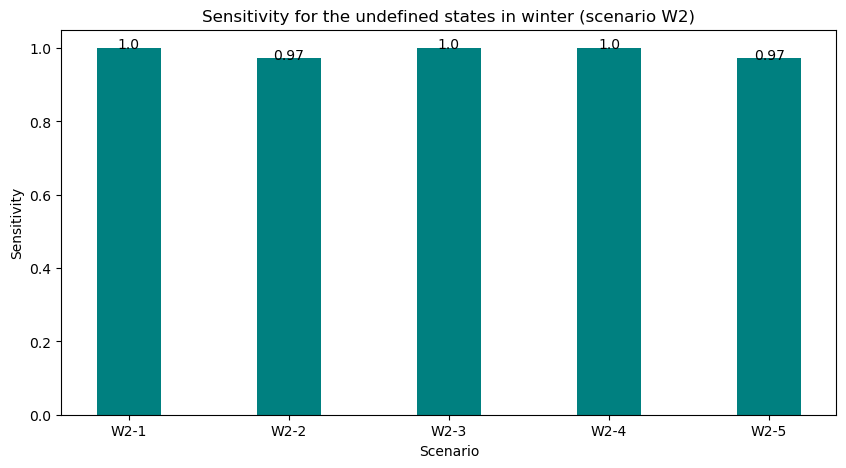

In [48]:
fig = plt.figure(figsize = (10, 5))
W = ['W2-1','W2-2','W2-3','W2-4','W2-5']
# creating the bar plot
plt.bar(W, ss, width = 0.4,color= 'teal')
addlabels(W, np.round(ss,2)) 
plt.xlabel("Scenario")
plt.ylabel("Sensitivity")
plt.title("Sensitivity for the undefined states in winter (scenario W2)")
plt.show()